# visualization

## import 

In [77]:
from __future__ import print_function
import sys
from syslog import LOG_MAIL

import os
from urllib3 import Retry
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import random
import argparse
import numpy as np
from PreResNet_cifar import *
import dataloader_cifar as dataloader
from math import log2
from Contrastive_loss import *

import collections.abc
from collections.abc import MutableMapping
from flow_trainer import FlowTrainer
from flowModule.utils import standard_normal_logprob
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline  

from config import argumentParse


os.environ['CUDA_VISIBLE_DEVICES'] = "2"
isBest = False
# model_save_loc = './checkpoint/cifar100_sym_0.9_flow_w_ce_base_64x4_d_u_0.7'
# model_save_loc = './checkpoint/cifar100_sym_0.2_flow_vis'
# model_save_loc = './checkpoint/cifar100_sym_0.2_flow_d_up_0.0_decay_0.99'
model_save_loc = './checkpoint/cifar100_sym_0.2_flow_mixEMA_UNICON_1.0_0.7_center_0.8_wo_feature_fc'
# model_save_loc = './checkpoint/cifar100_sym_0.9_flow_w_ce_base_64x4_d_u_0.7'
# model_save_loc = './checkpoint/cifar10_sym_0.5_flow_w_ce_base_w_reg'

config_path = './config/cifar100.yaml'
project_path = model_save_loc
num_samples = 50000
if not os.path.exists(model_save_loc + '/Density_distribution'):
        os.mkdir(model_save_loc + '/Density_distribution')

In [2]:
args = argumentParse(input_args=['--name', 'vis','--noise_mode','sym', '-r', '0', '--config_yaml', config_path])
args.cond_size = 512
args.centering = True
print("args : ",vars(args))

start to argument parse
args :  {'batch_size': 256, 'lr': 0.02, 'lr_f': 2e-05, 'noise_mode': 'sym', 'alpha': 4, 'linear_u': 100, 'lambda_u': 30, 'lambda_flow_u': 1, 'lambda_flow_u_warmup': 1, 'lambda_p': 50, 'lambda_c': 0.025, 'Tu': 0.7, 'Tu_warmup': 1.0, 'num_epochs': 350, 'ratio': 0.0, 'd_u': 0.7, 'tau': 5, 'd_up': 0, 'seed': 123, 'gpuid': '0', 'resume': False, 'num_class': 100, 'num_workers': 4, 'data_path': './data/cifar100', 'dataset': 'cifar100', 'flow_modules': '64-64-64-64', 'name': 'vis', 'fix': 'none', 'pretrain': '', 'pseudo_std': 0, 'decay': 0.99, 'warm_up': 30, 'num_samples': 50000, 'clip_grad': True, 'pretrained': False, 'split': False, 'cond_size': 512, 'isRealTask': False, 'useUncertainty': False, 'lambda_f': 1.0, 'weight_decay': 0.0005, 'flow_sp': True, 'centering': True, 'center_momentum': 0.8, 'w_ce': False, 'supcon': False, 'sharpening': 'UNICON', 'optimizer': 'SGD', 'pred': 'onlyEMA', 'tma_thr': 0.693, 'tma_decay': 0.0, 'config_yaml': './config/cifar100.yaml'}


## load model

In [3]:
if args.dataset== 'cifar10' or args.dataset== 'cifar100':
    from dataloader_cifar import cifar_dataloader as dataloader
    from PreResNet_cifar import *
    if args.dataset == 'cifar10':
        torchvision.datasets.CIFAR10(args.data_path,train=True, download=True)
        torchvision.datasets.CIFAR10(args.data_path,train=False, download=True)
    else:
        torchvision.datasets.CIFAR100(args.data_path,train=True, download=True)
        torchvision.datasets.CIFAR100(args.data_path,train=False, download=True)
elif args.dataset=='TinyImageNet':
    from PreResNet_tiny import *
    from dataloader_tiny import tinyImagenet_dataloader as dataloader
elif args.dataset=='WebVision':
    from InceptionResNetV2 import *
    from dataloader_webvision import webvision_dataloader as dataloader

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def create_model(args):
    if args.dataset=='WebVision':
        model = InceptionResNetV2(num_classes=args.num_class, feature_dim=args.cond_size)
    else:
        model = ResNet18(num_classes=args.num_class, feature_dim=args.cond_size)
    model = model.cuda()
    return model
net = create_model(args)

In [5]:
# flow model
flowTrainer = FlowTrainer(args)
flowNet = flowTrainer.create_model()
flowTrainer.setEma(net, flowNet)

Training T : 1.0
Number of trainable parameters of Point CNF: 391457


## Resume model

In [6]:
from Train_flow import load_model
load_model(model_save_loc, net, flowNet, flowTrainer, best=isBest)

## load data loader

In [7]:
if args.dataset== 'cifar10' or args.dataset== 'cifar100':
    loader = dataloader(args.dataset, r=args.ratio, noise_mode=args.noise_mode,batch_size=args.batch_size,num_workers=0,\
        root_dir=model_save_loc, noise_file='%s/clean_%.4f_%s.npz'%(args.data_path,args.ratio, args.noise_mode))
elif args.dataset== 'TinyImageNet':
    loader = dataloader(root=args.data_path, batch_size=args.batch_size, num_workers=4, ratio = args.ratio, noise_mode = args.noise_mode, noise_file='%s/clean_%.2f_%s.npz'%(args.data_path,args.ratio, args.noise_mode))
elif args.dataset == 'WebVision':
    loader = dataloader(batch_size=args.batch_size,num_workers=5,root_dir=args.data_path, num_class=args.num_class)

In [8]:
## Call the dataloader
test_loader = loader.run(0, 'val')
eval_loader = loader.run(0, 'eval_train')

## Distribution Alignment

In [55]:
def get_logits(net, flowNet, loader):
    for batch_idx, (inputs, targets) in tqdm(enumerate(loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]
        with torch.no_grad():
            with flowTrainer.net_ema.average_parameters():
                with flowTrainer.flowNet_ema .average_parameters():
                    _, _, feature = net(inputs, get_feature = True)
                    batch_size = feature.size()[0]                    
                    logits = flowTrainer.predict(flowNet, feature, mean = 0, std = 0, sample_n = 1, centering = False)
                    break
    return logits

@torch.no_grad()
def distribution_alignment(logits):
    print("logits ", logits.size())
    batch_size = logits.size(0)
    num_class = logits.size(1)
    _, logits_one_hot = logits.max(dim=1)

    weight = torch.zeros(num_class).cuda()

    for idx in range(num_class):
        class_ind = [i for i, x in enumerate(logits_one_hot) if x==idx]
        weight[idx] = (1 / num_class) / (len(class_ind) / batch_size)
        # print("class : ", idx, " weight : ", weight[idx].cpu().numpy(), " count : ", len(class_ind))
    
    logits_out = torch.mul(logits, weight)
    return logits_out

In [51]:
logits_DA = get_logits(net, flowNet, eval_loader)

0it [00:04, ?it/s]


In [56]:
distribution_alignment(logits_DA)

logits  torch.Size([2000, 100])
class :  0  weight :  1.1764706  count :  17
class :  1  weight :  1.1111112  count :  18
class :  2  weight :  1.25  count :  16
class :  3  weight :  0.7407407  count :  27
class :  4  weight :  0.7407407  count :  27
class :  5  weight :  0.90909094  count :  22
class :  6  weight :  1.1111112  count :  18
class :  7  weight :  0.8695652  count :  23
class :  8  weight :  0.90909094  count :  22
class :  9  weight :  1.25  count :  16
class :  10  weight :  1.3333334  count :  15
class :  11  weight :  0.7407407  count :  27
class :  12  weight :  1.0  count :  20
class :  13  weight :  1.3333334  count :  15
class :  14  weight :  1.8181819  count :  11
class :  15  weight :  1.0526316  count :  19
class :  16  weight :  1.3333334  count :  15
class :  17  weight :  1.1111112  count :  18
class :  18  weight :  1.4285715  count :  14
class :  19  weight :  1.1111112  count :  18
class :  20  weight :  1.1111112  count :  18
class :  21  weight :  1.1

tensor([[0.0127, 0.0000, 0.0000,  ..., 0.0000, 0.0121, 0.0000],
        [0.0119, 0.0000, 0.0000,  ..., 0.0000, 0.0130, 0.0000],
        [0.2191, 0.0000, 0.0000,  ..., 0.0000, 0.0141, 0.0000],
        ...,
        [0.0123, 0.0000, 0.0000,  ..., 0.0000, 0.0150, 0.0000],
        [0.0190, 0.0000, 0.0000,  ..., 0.0000, 0.0123, 0.0000],
        [0.0134, 0.0000, 0.0000,  ..., 0.0000, 0.0120, 0.0000]],
       device='cuda:0')

## Visualization feature

In [9]:
def Calculate_feature(net, flowNet, loader):
    print("Calculate_feature")
    all_features = []
    all_targets = []
    all_logits = []

    mean = 0
    std = 0
    for batch_idx, (inputs, targets) in tqdm(enumerate(loader)):
        # to one hot
        # targets = torch.zeros(loader.batch_size, args.num_class).scatter_(1, targets.view(-1,1), 1).unsqueeze(1)
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]
        with torch.no_grad():
            with flowTrainer.net_ema.average_parameters():
                with flowTrainer.flowNet_ema .average_parameters():
                    _, _, feature = net(inputs, get_feature = True)
                    batch_size = feature.size()[0]                    
                    logits = flowTrainer.predict(flowNet, feature, mean = 0, std = 0, sample_n = 1, centering = False)
                    _, logits_one_hot = logits.max(dim=1)
                    # print(logits_one_hot)
                    # print(targets)
                    all_features.append(feature.data.cpu())
                    all_targets.append(targets.data.cpu())
                    all_logits.append(logits_one_hot.data.cpu())
                    # print("feature", feature.size())
                    # print("targets", targets.size())
                    # print("logits", logits_one_hot.size())        
    all_features = torch.cat(all_features, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_logits = torch.cat(all_logits, dim=0)
    return all_features, all_targets, all_logits

In [10]:
features, targets, logits = Calculate_feature(net, flowNet, eval_loader)

0it [00:00, ?it/s]

Calculate_feature


25it [02:18,  5.54s/it]


In [11]:
from sklearn.manifold import TSNE
def embedded_feature(features_embedded, targets, logits):
    print("feature", features.shape)
    print("targets", targets.shape)
    print("logits", logits.shape)

    num_class = min(args.num_class, 10)
    
    class_ind = [i for i, x in enumerate(targets) if x<num_class]
    select_features_targets = features_embedded[class_ind]
    select_targets = targets[class_ind]
    
    
    class_ind = [i for i, (x, y) in enumerate(zip(targets, logits)) if x<num_class]
    select_features_logits = features_embedded[class_ind]
    select_logits = logits[class_ind]
    select_logits = torch.where(select_logits> 9 , 9, select_logits)
    
    return select_features_targets, select_targets, select_features_logits, select_logits

def class_acc(targets, logits):
    num_class = min(args.num_class, 100)
    total_acc = 0
    for idx in range(num_class):
        class_ind = [i for i, (x, y) in enumerate(zip(targets, logits)) if x==idx and x == y]
        class_ind_all = [i for i, (x, y) in enumerate(zip(targets, logits)) if x==idx]
        acc = len(class_ind) / len(class_ind_all)
        print("C : ", idx, "acc : ", round(acc * 100, 2), "%,count : ", len(class_ind_all))
        total_acc += acc
    print("total acc : ", round(total_acc / num_class * 100, 2), "%")

def embedded_feature_error(features_embedded, targets, logits):
    num_class = min(args.num_class, 10)
    
    class_ind = [i for i, (x, y) in enumerate(zip(targets, logits)) if x<num_class and x == y]
    select_features_T = features_embedded[class_ind]
    select_targets_T = targets[class_ind]
    
    
    class_ind = [i for i, (x, y) in enumerate(zip(targets, logits)) if x<num_class and x != y]
    select_features_E = features_embedded[class_ind]
    select_targets_E = targets[class_ind]    
        
    return select_features_T, select_targets_T, select_features_E, select_targets_E

def visualization_feature(features_embedded_t, targets_embedded, features_embedded_l, logits_embedded):
    %matplotlib inline  
    # Project PNG
    x_axis = features_embedded[:,0]
    y_axis = features_embedded[:,1]
    category = ['0','1','2','3','4','5','6','7','8','9']
    plt.figure(figsize=(36, 12))
    plt.subplot(121) 
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    scatter = plt.scatter(features_embedded_t[:,0], features_embedded_t[:,1], c=targets_embedded, alpha=0.3, cmap='tab10')
    print("*scatter.legend_elements() : ", *scatter.legend_elements())
    plt.legend(*scatter.legend_elements(), ncol = 10 , loc = "lower right")
    
    plt.grid(True)
    plt.subplot(122) 
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    plt.scatter(features_embedded_l[:,0], features_embedded_l[:,1], c=logits_embedded, alpha=0.3, cmap='tab10')
    # plt.subplot(222) 
    # plt.scatter(x_axis, y_axis, c=logits, alpha=0.3, cmap='tab10')
    plt.grid(True)
    plt.savefig("vis.png")
    plt.show()
    return

def visualization_TF(features_embedded_t, targets_embedded, features_embedded_l, logits_embedded):
    %matplotlib inline  
    # Project PNG
    x_axis = features_embedded[:,0]
    y_axis = features_embedded[:,1]
    category = ['0','1','2','3','4','5','6','7','8','9']
    plt.figure(figsize=(36, 12))
    plt.subplot(121) 
    # plt.xlim(0,1)
    # plt.ylim(0,1)
    scatter = plt.scatter(features_embedded_t[:,0], features_embedded_t[:,1], c='blue', alpha=0.3)
    scatter = plt.scatter(features_embedded_l[:,0], features_embedded_l[:,1], c='red', alpha=0.3)
    # print("*scatter.legend_elements() : ", *scatter.legend_elements())
    # plt.legend(*scatter.legend_elements(), ncol = 10 , loc = "lower right")
    plt.savefig("vis_TF.png")
    plt.grid(True)
    plt.show()
    return

### Test

In [12]:
features_embedded = TSNE(n_components=2, init='random', perplexity=3, verbose=0).fit_transform(features)

In [17]:
class_acc(targets, logits)

C :  0 acc :  95.2 %,count :  500
C :  1 acc :  86.6 %,count :  500
C :  2 acc :  65.2 %,count :  500
C :  3 acc :  64.2 %,count :  500
C :  4 acc :  60.0 %,count :  500
C :  5 acc :  85.0 %,count :  500
C :  6 acc :  84.8 %,count :  500
C :  7 acc :  76.2 %,count :  500
C :  8 acc :  91.2 %,count :  500
C :  9 acc :  86.8 %,count :  500
C :  10 acc :  67.8 %,count :  500
C :  11 acc :  55.4 %,count :  500
C :  12 acc :  81.2 %,count :  500
C :  13 acc :  77.2 %,count :  500
C :  14 acc :  75.6 %,count :  500
C :  15 acc :  82.0 %,count :  500
C :  16 acc :  76.8 %,count :  500
C :  17 acc :  91.2 %,count :  500
C :  18 acc :  75.0 %,count :  500
C :  19 acc :  72.4 %,count :  500
C :  20 acc :  92.4 %,count :  500
C :  21 acc :  83.0 %,count :  500
C :  22 acc :  81.4 %,count :  500
C :  23 acc :  88.2 %,count :  500
C :  24 acc :  89.6 %,count :  500
C :  25 acc :  76.4 %,count :  500
C :  26 acc :  68.8 %,count :  500
C :  27 acc :  73.2 %,count :  500
C :  28 acc :  83.4 %,count : 

In [13]:
features_embedded_t, targets_embedded, features_embedded_l, logits_embedded  = embedded_feature(features_embedded, targets, logits)

feature torch.Size([50000, 512])
targets torch.Size([50000])
logits torch.Size([50000])


*scatter.legend_elements() :  [<matplotlib.lines.Line2D object at 0x7f8df6f0cdd0>, <matplotlib.lines.Line2D object at 0x7f8f19884750>, <matplotlib.lines.Line2D object at 0x7f8f11fe74d0>, <matplotlib.lines.Line2D object at 0x7f8f11fe7610>, <matplotlib.lines.Line2D object at 0x7f8f11fe70d0>, <matplotlib.lines.Line2D object at 0x7f8df4bde510>, <matplotlib.lines.Line2D object at 0x7f8df4bde590>, <matplotlib.lines.Line2D object at 0x7f8df4bde350>, <matplotlib.lines.Line2D object at 0x7f8df4bde110>, <matplotlib.lines.Line2D object at 0x7f8df4bde290>] ['$\\mathdefault{0}$', '$\\mathdefault{1}$', '$\\mathdefault{2}$', '$\\mathdefault{3}$', '$\\mathdefault{4}$', '$\\mathdefault{5}$', '$\\mathdefault{6}$', '$\\mathdefault{7}$', '$\\mathdefault{8}$', '$\\mathdefault{9}$']


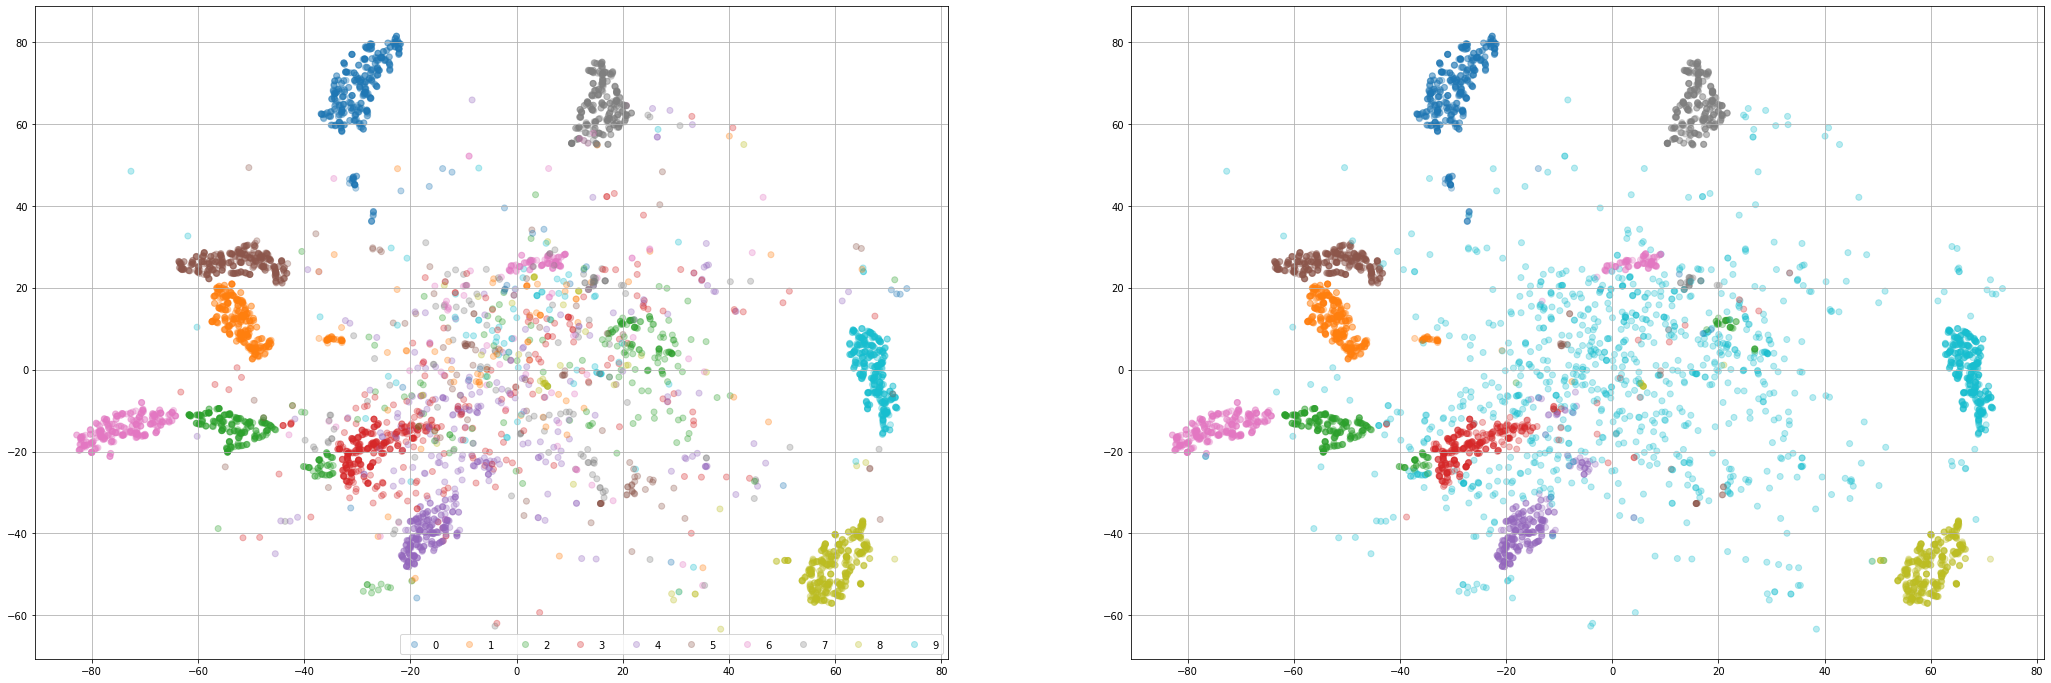

In [14]:
visualization_feature(features_embedded_t, targets_embedded, features_embedded_l, logits_embedded)

In [15]:
select_features_T, select_targets_T, select_features_E, select_targets_E = embedded_feature_error(features_embedded, targets, logits)

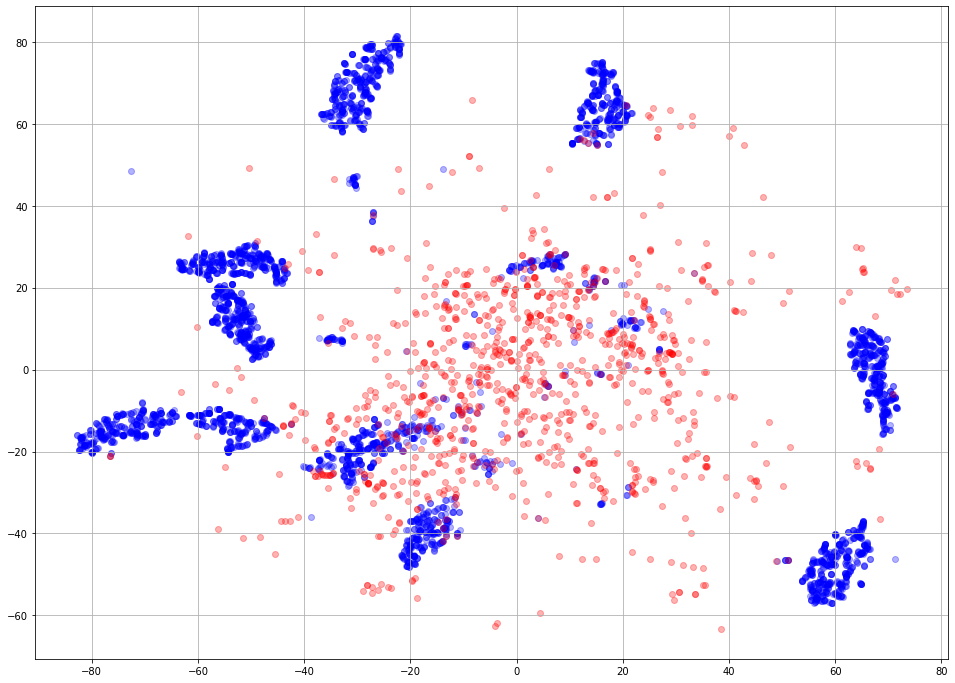

In [16]:
visualization_TF(select_features_T, select_targets_T, select_features_E, select_targets_E)

# old

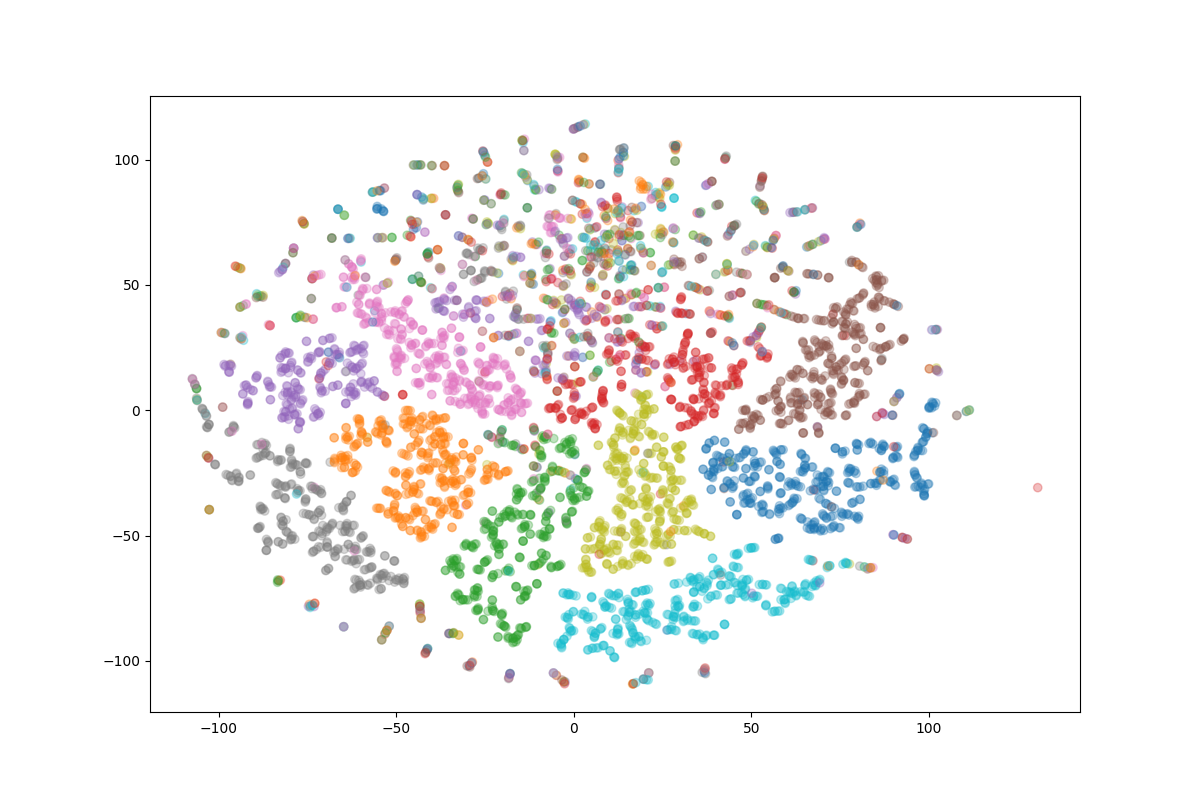

In [60]:
visualization_feature(features_embedded_t, targets_embedded, features_embedded_l, logits_embedded)

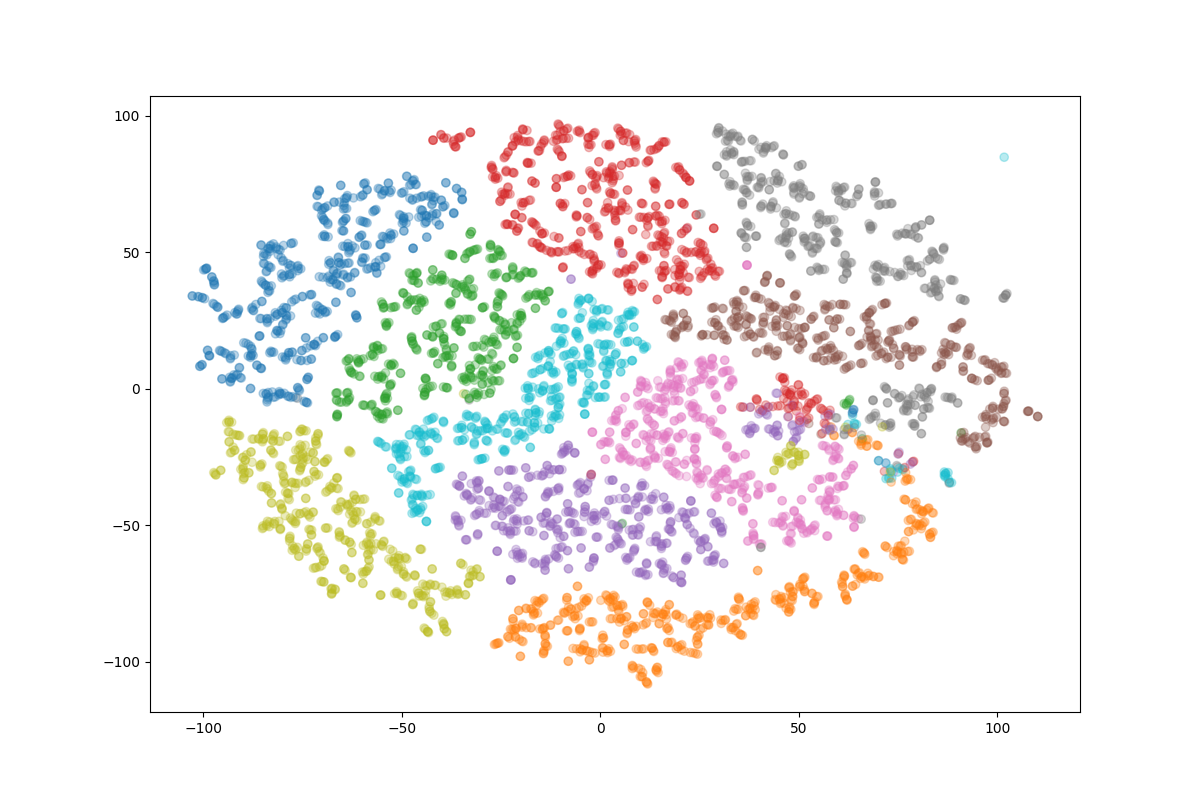

In [61]:
visualization_feature(features_embedded_l, logits_embedded)

## Calculate Density & JSD

In [94]:
def Calculate_Uncertainty_Sp(net, flowNet, num_samples, eval_loader):
    print("Calculate_Uncertainty Rand")
    uncertaintys   = torch.zeros(num_samples)  

    # sample_n = self.args.num_class
    sample_n = 1
    mean = 0
    std = 0
    batch_size = 100
    input_z = torch.normal(mean = mean, std = std, size=(sample_n * batch_size , args.num_class)).unsqueeze(1).cuda()
    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        # to one hot
        targets = torch.zeros(eval_loader.batch_size, args.num_class).scatter_(1, targets.view(-1,1), 1).unsqueeze(1)

        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network

        with torch.no_grad():
            with flowTrainer.net_ema.average_parameters():
                with flowTrainer.flowNet_ema .average_parameters():
                    _, logits, feature = net(inputs, get_feature = True)
                    batch_size = feature.size()[0]
                    feature = feature.repeat(sample_n, 1, 1)
                    # input_z = torch.normal(mean = mean, std = std, size=(sample_n * batch_size , args.num_class)).unsqueeze(1).cuda()
                    # input_z = torch.rand(sample_n * batch_size , self.args.num_class).unsqueeze(1).cuda()
                    delta_p = torch.zeros(input_z.shape[0], input_z.shape[1], 1).cuda()

                    approx21, _ = flowNet(input_z, feature, delta_p, reverse=True)
                    probs = torch.clamp(approx21, min=0)
                    # probs = torch.tanh(approx21)
                    # print("probs tanh", probs.size(), probs[:1])
                    # probs = torch.clamp(probs, min=0, max=1)
                    # print("probs clamp", probs.size(), probs[:1])
                    probs = F.normalize(probs, dim=2, p=1)
                    # print("probs norm", probs.size(), probs[:1])
                    probs = probs.view(sample_n, batch_size, args.num_class)
                    probs_mean = torch.mean(probs, dim=0, keepdim=False)
                    # print("probs", probs.size())
                    entropy_val = flowTrainer.entropy(probs_mean)
                    # print("entropy_val", entropy_val.size())
                    # print("probs_mean", probs_mean.size())

        ## Get the Prediction
        uncertaintys[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = entropy_val
    return uncertaintys

In [95]:
# uncertaintys = Calculate_Uncertainty_Sp(net, flowNet, args.num_samples, eval_loader)

In [96]:
print("Calculate Density")
density = flowTrainer.Calculate_Density(net, flowNet, args.num_samples, eval_loader)
# density = uncertaintys

Calculate Density


500it [03:12,  2.60it/s]


In [97]:
print("Calculate JSD")
prob = flowTrainer.Calculate_JSD(net, flowNet, args.num_samples, eval_loader)
prob_bk = prob.clone()

Calculate JSD


500it [04:03,  2.05it/s]


## JSD thr

In [98]:
from Train_flow import Selection_Rate
SR , threshold = Selection_Rate(args, prob.clone())
print("SR: ", SR)
print("threshold: ", threshold)

threshold :  tensor(0.4918)
threshold(new) :  tensor(0.4918)
prob size :  torch.Size([50000])
down : 29284
up : 20716
SR:  0.58568
threshold:  tensor(0.4918)


In [99]:
labeled_trainloader, unlabeled_trainloader = loader.run(SR, 'train', prob= prob, densitys=density) # Uniform Selection

## log JSD

In [101]:
bins = 40
if isBest:
    model_name = 'Best_density'
else:
    model_name = 'warmup_density'
labeled_idx = labeled_trainloader.dataset.pred_idx
unlabeled_idx = unlabeled_trainloader.dataset.pred_idx
origin_prob =  prob_bk
origin_densitys = density
labeled_prob = [origin_prob[i] for i in labeled_idx]
unlabeled_prob = [origin_prob[i] for i in unlabeled_idx]
sample_ratio = torch.sum(prob<threshold).item()/args.num_samples

num_cleanset, num_noiseset = len(labeled_trainloader.dataset), len(unlabeled_trainloader.dataset)
num_wholeset = num_cleanset + num_noiseset

cleanset_o_label, cleanset_n_label = labeled_trainloader.dataset.origin_label, labeled_trainloader.dataset.noise_label
noiseset_o_label, noiseset_n_label = unlabeled_trainloader.dataset.origin_label, unlabeled_trainloader.dataset.noise_label

cleanset_noise_mask = (cleanset_o_label != cleanset_n_label).astype(float)
noiseset_noise_mask = (noiseset_o_label != noiseset_n_label).astype(float)

num_cleanset_noise = cleanset_noise_mask.sum()
num_noiseset_noise = noiseset_noise_mask.sum()
num_noise = num_cleanset_noise + num_noiseset_noise

num_cleanset_clean = num_cleanset - num_cleanset_noise
num_noiseset_clean = num_noiseset - num_noiseset_noise
num_clean = num_wholeset - num_noise

eps = 1e-20
clean_recall = num_cleanset_clean / (num_clean + eps)
clean_precision = num_cleanset_clean / (num_cleanset + eps)
clean_f1 = (2 * clean_recall * clean_precision) / (clean_recall + clean_precision + eps)

noise_recall = num_noiseset_noise / (num_noise + eps)
noise_precision = num_noiseset_noise / (num_noiseset + eps)
noise_f1 = (2 * noise_recall * noise_precision) / (noise_recall + noise_precision + eps)

# draw JSD dis
clean_prob = []
noise_prob = []
clean_density = []
noise_density = []
for idx_noise_zip in [zip(labeled_idx, cleanset_noise_mask), zip(unlabeled_idx, noiseset_noise_mask)]:
    for idx, is_noise in idx_noise_zip:
        p = origin_prob[idx]
        d = -origin_densitys[idx]
        if is_noise == 1.0:
            noise_prob.append(float(p))
            noise_density.append(float(d))
        else:
            clean_prob.append(float(p))
            clean_density.append(float(d))

plt.clf()
kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, bins=bins)
plt.hist(clean_prob, color='green', range=(0., 1.), label='clean', **kwargs)
plt.hist(noise_prob, color='red'  , range=(0., 1.), label='noisy', **kwargs)

plt.axvline(x=threshold,          color='black')
plt.axvline(x=origin_prob.mean(), color='gray')
plt.xlabel('JSD Values')
plt.ylabel('count')
plt.title(f'JSD Distribution of N Samples:{model_name}')
plt.xlim(0, 1)
plt.grid(True)
plt.savefig(f'{model_save_loc}/Density_distribution/JSD_{model_name}.png')

plt.clf()
kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, bins=bins)
plt.axvline(x=-origin_densitys.mean(), color='gray')
plt.hist(clean_density, color='green',range=(8900., 9100.), label='clean', **kwargs)
plt.hist(noise_density, color='red'  ,range=(8900., 9100.), label='noisy', **kwargs)

# plt.axvline(x=-origin_densitys.mean(), color='gray')
plt.xlabel('Density Values')
plt.ylabel('count')
plt.title(f'Density Distribution of N Samples :{model_name}')
plt.grid(True)
plt.savefig(f'{model_save_loc}/Density_distribution/Density_{model_name}.png')

In [50]:
origin_prob =  prob
origin_densitys = density
plt.clf()
# max_point = 5000.
# vis_count = max_point * (len(clean_prob) / (len(clean_prob) + len(noise_prob)))
# for idx, (jsd_value, density_value) in tqdm(enumerate(zip(clean_prob, clean_density))):
#     plt.scatter(jsd_value, density_value, c = 'green', s = 8, alpha = .3,marker = "o")
#     if idx > vis_count:
#         break

# for idx, (jsd_value, density_value) in tqdm(enumerate(zip(noise_prob, noise_density))):
#     plt.scatter(jsd_value, density_value, c = 'blue', s = 8, alpha = .3,marker = "x")
#     if idx > (max_point - vis_count):
#         break

for idx_noise_zip in [zip(labeled_idx, cleanset_noise_mask), zip(unlabeled_idx, noiseset_noise_mask)]:
    for idx, is_noise in tqdm(idx_noise_zip):
        if random.random() > 0.2:
            continue
        if is_noise == 1.0:
            plt.scatter(origin_prob[idx], origin_densitys[idx], c = 'green', s = 8, alpha = .3,marker = "o")
        else:
            plt.scatter(origin_prob[idx], origin_densitys[idx], c = 'blue', s = 8, alpha = .3,marker = "x")

plt.xlabel('JSD')
plt.ylabel('Uncertainty')
plt.title(f' Joint distribution of loss values and epistemic uncertainty  :{model_name}')
plt.grid(True)
plt.savefig(f'{model_save_loc}/Density_distribution/{model_name}_jsd_uncertainty.png')

23363it [02:03, 189.42it/s]
26700it [06:37, 67.18it/s] 


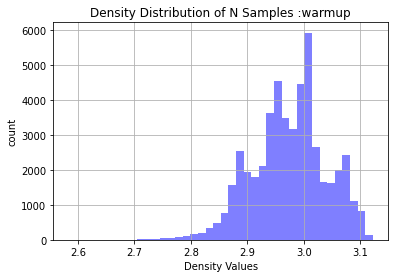

In [37]:
%matplotlib inline  


plt.clf()

kwargs = dict(histtype='stepfilled', alpha=0.5, density=False, bins=40)
plt.hist(uncertaintys, color='blue', label='clean', **kwargs)
# plt.hist(noise_density, color='red'  , label='noisy', **kwargs)

# plt.axvline(x=-origin_densitys.mean(), color='gray')
plt.xlabel('Density Values')
plt.ylabel('count')
plt.title(f'Density Distribution of N Samples :{model_name}')
plt.grid(True)
plt.show()

## 以下為舊Code

In [ ]:
def entropy(p, dim=1):
    return -p.mul((p + 1e-20).log2()).sum(dim=1)

In [ ]:
x = torch.zeros(10, 3)
x[:,0] = 0.
x[:,1] = 0.5
x[:,2] = 0.5
e = entropy(x)
print(x)
print(e)

In [50]:
## Test Accuracy
def test(net1,net2):
    net1.eval()
    net2.eval()

    num_samples = 1000
    correct = 0
    total = 0
    loss_x = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.cuda(), targets.cuda()
            _, outputs1 = net1(inputs)
            _, outputs2 = net2(inputs)           
            outputs = outputs1+outputs2
            _, predicted = torch.max(outputs, 1)            
#             loss = CEloss(outputs, targets)  
#             loss_x += loss.item()

            total += targets.size(0)
            correct += predicted.eq(targets).cpu().sum().item()  

    acc = 100.*correct/total
    return acc

In [8]:
if isFlow:
    acc_flow_warmup, confidence_warmup = flowTrainer.testByFlow(net_warmup, flowNet_warmup, test_loader)
    acc_flow, confidence = flowTrainer.testByFlow(net, flowNet, test_loader)
    print("acc(warmup) ", acc_flow_warmup, ", acc(flow) = ", acc_flow)
    print("confidence(warmup) ", confidence_warmup, ", confidence(flow) = ", confidence)
else:
    acc = test(net,net_2)
    acc_warmup = test(net_warmup,net_warmup_2)
    print("acc(warmup) ", acc_warmup, ", acc(flow) = ", acc)

acc(warmup)  34.09 , acc(flow) =  61.2
confidence(warmup)  0.12860390090942384 , confidence(flow) =  0.5537863014221192


## compare JSD, flow density

In [11]:
# KL divergence
def kl_divergence(p, q):
    return (p * ((p+1e-10) / (q+1e-10)).log()).sum(dim=1)

## Jensen-Shannon Divergence 
class Jensen_Shannon(nn.Module):
    def __init__(self):
        super(Jensen_Shannon,self).__init__()
        pass
    def forward(self, p,q):
        m = (p+q)/2
        return 0.5*kl_divergence(p, m) + 0.5*kl_divergence(q, m)
## Calculate JSD
def Calculate_JSD(model1, model2, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            out1 = torch.nn.Softmax(dim=1).cuda()(model1(inputs)[1])     
            out2 = torch.nn.Softmax(dim=1).cuda()(model2(inputs)[1])

        ## Get the Prediction
        out = (out1 + out2)/2     

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist
    return JSD

def Calculate_JSD_Flow(net, flowNet, num_samples):  
    JS_dist = Jensen_Shannon()
    JSD   = torch.zeros(num_samples)    

    for batch_idx, (inputs, targets, index) in tqdm(enumerate(eval_loader)):
        inputs, targets = inputs.cuda(), targets.cuda()
        batch_size = inputs.size()[0]

        ## Get outputs of both network
        with torch.no_grad():
            feature = net(inputs)[0]
            out = flowTrainer.predict(flowNet, feature)

        ## Divergence clculator to record the diff. between ground truth and output prob. dist.  
        dist = JS_dist(out,  F.one_hot(targets, num_classes = args.num_class))
        JSD[int(batch_idx*batch_size):int((batch_idx+1)*batch_size)] = dist

    return JSD

In [12]:
if isFlow:
    prob = Calculate_JSD_Flow(net, flowNet, num_samples)
    # prob = Calculate_JSD_Flow(net_warmup, flowNet_warmup, num_samples)
else:
    prob = Calculate_JSD(net, net_2, num_samples)
#     prob = Calculate_JSD(net_warmup, net_warmup_2, num_samples)
threshold = torch.mean(prob)
if threshold.item()>args.d_u:
    threshold = threshold - (threshold-torch.min(prob))/args.tau
SR = torch.sum(prob<threshold).item()/num_samples    

500it [01:37,  5.15it/s]


In [13]:
labeled_trainloader, unlabeled_trainloader = loader.run(SR, 'train', prob = prob) # Uniform Selection

labeled_idx = labeled_trainloader.dataset.pred_idx
unlabeled_idx = unlabeled_trainloader.dataset.pred_idx
class_ind = labeled_trainloader.dataset.class_ind
origin_prob =  labeled_trainloader.dataset.origin_prob
labeled_prob = [origin_prob[i].numpy() for i in labeled_idx]
unlabeled_prob = [origin_prob[i].numpy() for i in unlabeled_idx]
sample_ratio = torch.sum(prob<threshold).item()/num_samples

In [14]:
noise_label = np.load(noise_file)['label']
noise_idx = np.load(noise_file)['index']
idx       = list(range(50000))
clean_idx = [x for x in idx if x not in noise_idx]

In [15]:
## True Positive
TP = [x for x in labeled_idx if x in clean_idx]
## False Positive
FP = [x for x in labeled_idx if x in noise_idx]

In [16]:
print("TP :", len(TP), "FP:", len(FP))

TP : 4789 FP: 6069


In [17]:
TP_classes = []
NP_classes = []
for i in range(0, 10):
    TP_classes.append(len([x for x in TP if x in class_ind[i]]))
    NP_classes.append(len([x for x in FP if x in class_ind[i]]))

## Selection (TP FP)

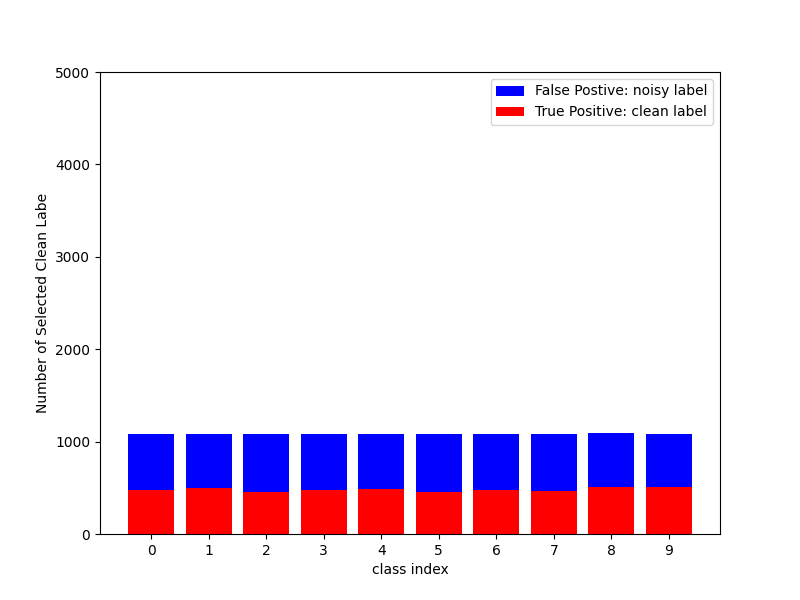

In [22]:
label = ['0','1','2','3','4','5','6','7','8','9']

plt.figure(figsize=(8,6))
x = np.arange(len(label))
plt.bar(x, NP_classes, color='blue', label='False Postive: noisy label', bottom=TP_classes)
plt.bar(x, TP_classes, color='red', label='True Positive: clean label')

plt.xticks(x, label)
plt.xlabel('class index')
plt.ylabel('Number of Selected Clean Labe')
plt.legend(loc='upper right')
plt.ylim((0,5000))
plt.show()

## JSD distribution

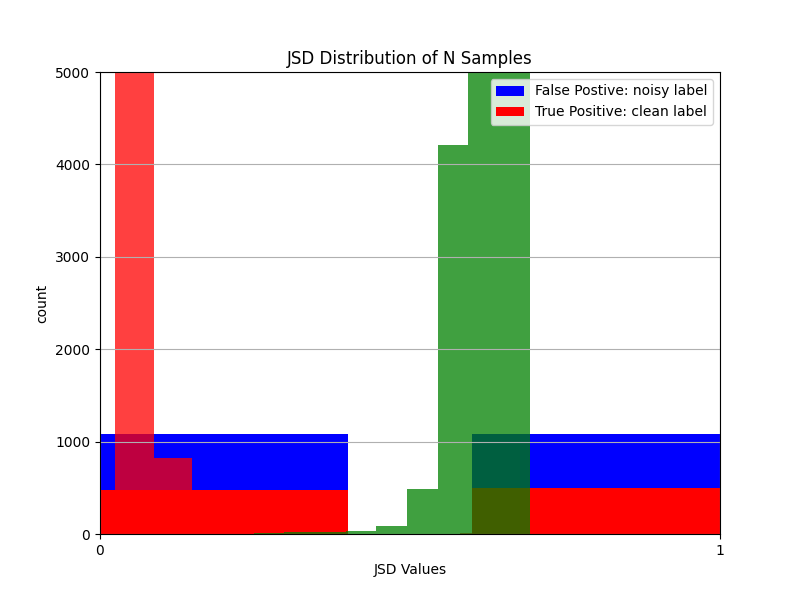

In [23]:
# the histogram of the data

labeled_prob = np.array(labeled_prob)
unlabeled_prob = np.array(unlabeled_prob)

# label_data = np.sort(labeled_prob)
# label_data_y = np.arange(len(label_data))/float(len(label_data))
# plt.plot(label_data, label_data_y)


# unlabeled_data = np.sort(unlabeled_prob)
# unlabeled_data_y = np.arange(len(unlabeled_data))/float(len(unlabeled_data))
# plt.plot(unlabeled_data, unlabeled_data_y)

kwargs = dict(histtype='stepfilled', alpha=0.75, density=False, bins=10)
# plt.hist(np.array(origin_prob), **kwargs)
plt.hist(labeled_prob, color = 'r', **kwargs)
plt.hist(unlabeled_prob, color = 'g',  **kwargs)


plt.xlabel('JSD Values')
plt.ylabel('count')
plt.title('JSD Distribution of N Samples')
plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.grid(True)
plt.show()

## Get density

In [12]:
def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda()
    return torch.index_select(a, dim, order_index)
def generateDensity(encoder, flownet, dataloader):
    encoder.eval()
    flownet.eval()
    
    approx21_vec = []
    log_p2_vec = []
    num_iter = (len(dataloader.dataset)//dataloader.batch_size)+1
    with torch.no_grad():
        input_y = torch.zeros(size=(dataloader.batch_size * args.num_class, 1, args.num_class)).cuda()
        for b in range(dataloader.batch_size):
            for c in range(args.num_class):
                input_y[args.num_class * b + c, 0, c] = 1.
        print(input_y[:10])
        for batch_idx, (inputs, labels) in tqdm(enumerate(dataloader)):
            inputs, labels = inputs.cuda(), labels.cuda() 
            feature, _ = encoder(inputs)
            feature = F.normalize(feature, dim=1)
#             print(feature[:5])
            feature = tile(feature, 0, args.num_class).unsqueeze(0)
            delta_p = torch.zeros(input_y.shape[0], input_y.shape[1], 1).cuda()
#             print(input_y.size(), feature.size(), delta_p.size())
#             print(input_y[:2], feature[:2], delta_p[:2])
            approx21, delta_log_p2 = flownet(input_y, feature, delta_p)
            approx2 = standard_normal_logprob(approx21).view(input_y.size()[0], -1).sum(1, keepdim=True)
            delta_log_p2 = delta_log_p2.view(input_y.size()[0], input_y.shape[1], 1).sum(1)
            log_p2 = (approx2 - delta_log_p2)
            approx21_vec.append(approx21.data.cpu())
            log_p2_vec.append(log_p2.data.cpu())
        approx21_vec = torch.cat(approx21_vec, dim=0)
        log_p2_vec = torch.cat(log_p2_vec, dim=0)
#             print(approx21.size())
#             print(approx2.size())
            
    return approx21_vec, log_p2_vec, dataloader.dataset.test_label

In [324]:
approx21, density,labels  = generateDensity(net, flowNet, test_loader)
print(approx21[20:30])
print(density[20:30])
print(labels[2:3])
print(approx21.size())
print(density.size())
print(len(labels))

0it [00:00, ?it/s]

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]], device='cuda:0')


100it [00:28,  3.55it/s]

tensor([[[ 8.3192e+00, -3.1501e+00,  1.6775e-01,  2.8688e-02,  1.2270e-01,
           1.1613e-01,  9.3875e-02, -3.9935e-01, -5.3352e+00,  4.9174e-02]],

        [[-2.3456e-02,  6.9501e+00,  1.8058e-01,  4.3245e-02,  1.0382e-01,
           1.2864e-01,  9.9754e-02, -4.6514e-01, -5.3899e+00,  5.6694e-02]],

        [[ 4.9999e-03, -3.1361e+00,  8.1212e+00,  3.1997e-02,  9.5456e-02,
           1.1967e-01,  9.9832e-02, -4.7993e-01, -5.3717e+00,  6.7844e-02]],

        [[ 5.3395e-04, -3.1359e+00,  1.8669e-01,  7.5407e+00,  9.3633e-02,
           1.1946e-01,  9.8797e-02, -4.7059e-01, -5.3823e+00,  5.7551e-02]],

        [[-4.3824e-02, -3.1540e+00,  1.5208e-01,  4.3649e-02,  7.9513e+00,
           1.2663e-01,  9.4666e-02, -3.8400e-01, -5.3305e+00,  4.7158e-02]],

        [[-3.9439e-02, -3.1495e+00,  1.6363e-01,  4.3264e-02,  1.3266e-01,
           7.7934e+00,  9.4061e-02, -3.9082e-01, -5.3402e+00,  4.5323e-02]],

        [[-4.2476e-02, -3.1521e+00,  1.5463e-01,  4.7195e-02,  1.4616e-01,
       

In [325]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(density.cpu().numpy())
X_embedded.shape

(100000, 2)

In [330]:
emb_dist = {}
labels10 = [0,1,2,3,4,5,6,7,8,9]
for i in [0,1,2,3,4,5,6,7,8,9]:
    ix = np.where(i == np.asarray(labels10))
    emb_dist[i] = X_embedded[ix]

In [331]:
def pltDis(target ,emb):
    result = np.array(emb)
    print(len(result))
    result_min, result_max = result.min(), result.max()
    result_norm = (result - result_min) / (result_max - result_min)
    # Project PNG
    x_axis = result_norm[:,0]
    y_axis = result_norm[:,1]
    count = int(len(result) / 10)
    c =  np.array([0,1,2,3,4,5,6,7,8,9] * count)
    plt.figure(figsize=(12, 12))
#     plt.xlim(0,1)
#     plt.ylim(0,1)

    cdict = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5:'tab:brown', 6:'tab:pink', 7:'tab:gray', 8:'tab:olive', 9:'tab:cyan'}

    for color in np.unique(c):
        ix = np.where(c == color)
        if target == color:
            m = '*'
        else:
            m = 'o'
        plt.scatter(x_axis[ix], y_axis[ix], c=cdict[color], alpha=0.3, marker = m)
    plt.legend(['0','1','2','3','4','5','6','7','8','9'])
    plt.savefig('DR.png')

100000


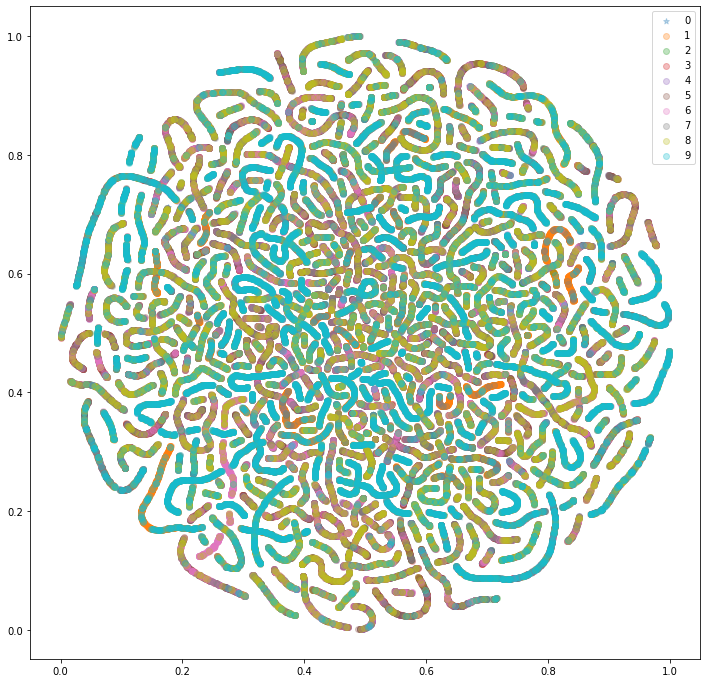

In [332]:
pltDis(0, X_embedded)

In [19]:
def pltDisV2(target, emb, density):
    result = np.array(emb)
    result_min, result_max = result.min(), result.max()
    result_norm = (result - result_min) / (result_max - result_min)
    # Project PNG
    x_axis = result_norm[:,0]
    y_axis = result_norm[:,1]
    z_axis = density
    c =  labels10
    plt.figure(figsize=(12, 12))
    ax = plt.axes(projection='3d')

#     plt.xlim(0,1)
#     plt.ylim(0,1)

    cdict = {0: 'tab:blue', 1: 'tab:orange', 2: 'tab:green', 3: 'tab:red', 4: 'tab:purple', 5:'tab:brown', 6:'tab:pink', 7:'tab:gray', 8:'tab:olive', 9:'tab:cyan'}
    m = ['o', '*', 's', 'P', 'p', 'x', 'X', 'd', 'h', 'H']

    for color in np.unique(c):
        ix = np.where(c == color)
        ij = []
#         print(color)
#         print(ix[0][:20])
        for j in ix[0]:
            if (j % 10) == color:
                ij.append(j)
        if (color == target):
            ax.scatter(x_axis[ix], y_axis[ix], z_axis[ix],  c=cdict[0], alpha=0.1, marker = m[color])
            ax.scatter(x_axis[ij], y_axis[ij], z_axis[ij], c=cdict[3], alpha=1, marker = 'H')

    plt.legend(['0','1','2','3','4','5','6','7','8','9'])
    plt.savefig('DR.png')
    plt.show()

In [20]:
pltDisV2(5, X_embedded, density)

NameError: name 'X_embedded' is not defined

In [8]:
def showDensity(data, classId):
    # plt.cla()
    plt.figure(figsize=(12,6))

    label=['0','1','2','3','4','5','6','7','8','9', 'c']
    color=['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red']
    x=np.arange(len(label)) 
    ax=plt.gca()
    plt.title(f"Density (label : {classId})") 
    bars = ax.bar(x, data, tick_label=label, color = color)
    ax.bar_label(bars)
    plt.grid(True)
    plt.xlabel('Class')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

In [9]:
def iter_load_model(mID):
    # path = './checkpoint/cifar10_sym_0.9_flow_lambda_u_3_lin_u_340_tau_2.5_saveAll'
    path = './checkpoint/cifar10_sym_0.9_flow_lambda_u_3_lin_u_340_tau_2.5_fixbug'
    model_name = f'Net_{mID}.pth'
    model_name_flow = f'FlowNet_{mID}.pth'
    net.load_state_dict(torch.load(os.path.join(path, model_name))['net'])
    flowNet.load_state_dict(torch.load(os.path.join(path, model_name_flow))['net'])
    return net, flowNet

In [10]:
def drawBar(data):
    langs=['0','1','2','3','4','5','6','7','8','9']
    plt.ylim(0, 1)
    plt.bar(langs,data)
    plt.show()

In [1]:
%matplotlib inline

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, FloatSlider, IntSlider
from IPython.display import Image

test_b1_loader = loader.run(0, 'test')
@interact
def visDensity(
    idx = IntSlider(min=0, max=test_b1_loader.batch_size - 1, step=1, value=0),
    modelIdx = IntSlider(min=0, max=23, step=1, value=0),
    modelType = widgets.RadioButtons(options=['best', 'warmup', 'debug'], value='best', description='modelType', disabled=False),
    viewer = widgets.RadioButtons(options=['density', 'sharpen'], value='density', description='viewer', disabled=False),
    T = FloatSlider(min=0., max=5., value=0.5, step=0.01),
    inputX_0 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_1 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_2 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_3 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_4 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_5 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_6 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_7 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_8 = FloatSlider(min=0., max=1., value=0., step=0.01),
    inputX_9 = FloatSlider(min=0., max=1., value=0., step=0.01),
):
    print("modelType : ", modelType)
    if (modelType == 'best'):
        netModel = net
        flowModel = flowNet
    elif(modelType == 'warmup'):
        netModel = net_warmup
        flowModel = flowNet_warmup
    elif(modelType == 'debug'):
        netModel, flowModel = iter_load_model(modelIdx)
    netModel.eval()
    flowModel.eval()   
    approx21_vec = []
    log_p2_vec = []
    preidct_vec = []
    data_size = args.num_class + 1
    inputX = [inputX_0, inputX_1, inputX_2,inputX_3,inputX_4,inputX_5,inputX_6,inputX_7,inputX_8,inputX_9]
    inputX = torch.FloatTensor(inputX)

    with torch.no_grad():
        input_y = torch.zeros(size=(test_b1_loader.batch_size * data_size, 1, args.num_class)).cuda()
        for b in range(test_b1_loader.batch_size):
            for c in range(args.num_class):
                input_y[(data_size * b) + c, 0, c] = 1.
            input_y[(data_size * b) + 10] = inputX
            
        for batch_idx, (inputs, labels) in enumerate(test_b1_loader):
            inputs, labels = inputs.cuda(), labels.cuda() 
            feature, _ = netModel(inputs)
            feature = F.normalize(feature, dim=1)
            # get density
            feature_rp = tile(feature, 0, data_size).unsqueeze(0)
            delta_p = torch.zeros(input_y.shape[0], input_y.shape[1], 1).cuda()
            # print("input_y", input_y.size())
            # print("feature_rp", feature_rp.size())
            # print("delta_p", delta_p.size())
            approx21, delta_log_p2 = flowModel(input_y, feature_rp, delta_p)
            approx2 = standard_normal_logprob(approx21).view(input_y.size()[0], -1).sum(1, keepdim=True)
            delta_log_p2 = delta_log_p2.view(input_y.size()[0], input_y.shape[1], 1).sum(1)
            log_p2 = (approx2 - delta_log_p2)
            approx21_vec.append(approx21.data.cpu())
            log_p2_vec.append(log_p2.data.cpu())
            
            # get predict
            input_z = torch.normal(mean = 0, std = 0, size=(test_b1_loader.batch_size, 1, args.num_class)).cuda()
            delta_p = torch.zeros(input_z.shape[0], input_z.shape[1], 1).cuda()
            # print("input_z", input_z.size())
            # print("feature", feature.size())
            # print("delta_p", delta_p.size())
            approx21, _ = flowModel(input_z, feature, delta_p, reverse=True)
            # print("approx21", approx21.size() , approx21[idx])
            probs = torch.clamp(approx21, min=0, max=1)
            # print("probs_1", probs.size(), probs[idx])
            probs = probs.view(1, -1, args.num_class)
            # print("probs_2", probs.size(), probs[:3])
            probs_mean = torch.mean(probs, dim=0, keepdim=False)
            probs_mean = F.normalize(probs_mean, dim=1, p=1)
            preidct_vec.append(probs_mean.data.cpu())
            _, predicted = torch.max(probs_mean, 1)
            # print("predicted : ", predicted[idx])
            break
        approx21_vec = torch.cat(approx21_vec, dim=0)
        log_p2_vec = torch.cat(log_p2_vec, dim=0)
        preidct_vec = torch.cat(preidct_vec, dim=0)
        pu = preidct_vec**(1/T)
        preidct_sharpen_vec = pu / pu.sum(dim=1, keepdim=True)
        # print("preidct_vec : ", preidct_vec[idx])
        # print("preidct_sharpen : ", preidct_sharpen_vec[idx])
        # print("GT : ", test_b1_loader.dataset.test_label[idx])
        if (viewer == "sharpen"):
            drawBar(preidct_vec[idx].numpy())
            drawBar(preidct_sharpen_vec[idx].numpy())
        elif(viewer == "density"):
            print("X_c : ", inputX)
            showDensity(log_p2_vec[idx*11:(idx + 1)*11], test_b1_loader.dataset.test_label[idx])
    return 

NameError: name 'loader' is not defined

In [126]:
def draw_bar(logit, loss):
    print("loss : ", loss)
    print("sum : ", torch.sum(a))
    print("max : ", logit.max())
    print("min : ", logit.min())
    class_num = logit.size(0)
    x = np.arange(0,class_num).tolist()
    plt.bar(x, logit, color = 'b')
    plt.xlim(0,50)
    plt.ylim(0,0.5)
    plt.show()

loss :  87.4258
sum :  tensor(1.0000)
max :  tensor(0.0744)
min :  tensor(0.)


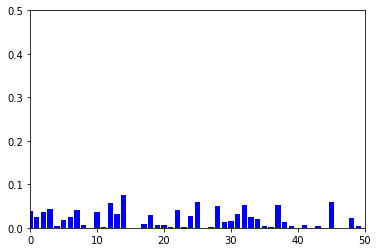

In [130]:
draw_bar(a, 87.4258)

loss :  -88.5422
sum :  tensor(1.0000)
max :  tensor(0.5876)
min :  tensor(0.)


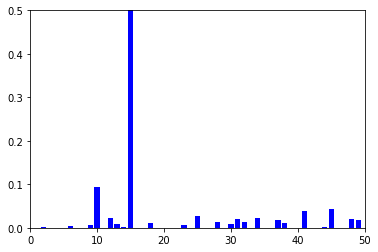

In [132]:
draw_bar(b, -88.5422)

loss :  -27.7
sum :  tensor(1.0000)
max :  tensor(0.1152)
min :  tensor(0.)


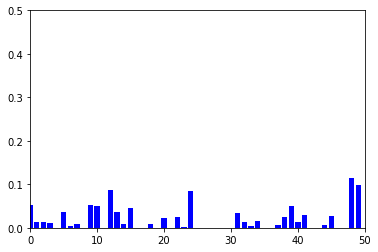

In [135]:
draw_bar(c, -27.7)

loss :  0.97
sum :  tensor(1.0000)
max :  tensor(0.3910)
min :  tensor(0.)


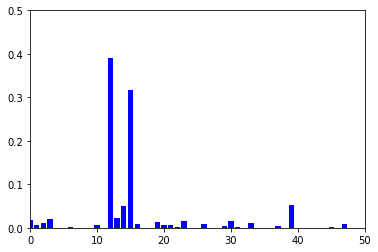

In [139]:
draw_bar(d, 0.97)

loss :  1191
sum :  tensor(1.0000)
max :  tensor(0.1603)
min :  tensor(0.)


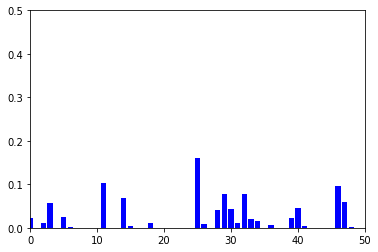

In [142]:

draw_bar(loss1191, 1191)

In [128]:
a =torch.tensor([3.9515e-02, 2.5290e-02, 3.5722e-02, 4.2082e-02, 3.4465e-03, 1.7532e-02,
         2.4645e-02, 4.0955e-02, 5.7994e-03, 0.0000e+00, 3.7349e-02, 2.8661e-03,
         5.7696e-02, 3.0962e-02, 7.4404e-02, 0.0000e+00, 0.0000e+00, 7.7934e-03,
         2.8413e-02, 5.5994e-03, 5.7049e-03, 2.8799e-03, 4.1890e-02, 2.2678e-03,
         2.7046e-02, 6.0197e-02, 0.0000e+00, 1.6942e-03, 4.9479e-02, 1.2911e-02,
         1.6591e-02, 3.1650e-02, 5.1589e-02, 2.3870e-02, 2.0519e-02, 3.5645e-03,
         2.8043e-03, 5.2273e-02, 1.4328e-02, 3.9927e-03, 0.0000e+00, 5.6221e-03,
         2.0787e-04, 5.0415e-03, 0.0000e+00, 5.8228e-02, 0.0000e+00, 0.0000e+00,
         2.1887e-02, 3.6945e-03])

In [129]:
a

tensor([0.0395, 0.0253, 0.0357, 0.0421, 0.0034, 0.0175, 0.0246, 0.0410, 0.0058,
        0.0000, 0.0373, 0.0029, 0.0577, 0.0310, 0.0744, 0.0000, 0.0000, 0.0078,
        0.0284, 0.0056, 0.0057, 0.0029, 0.0419, 0.0023, 0.0270, 0.0602, 0.0000,
        0.0017, 0.0495, 0.0129, 0.0166, 0.0316, 0.0516, 0.0239, 0.0205, 0.0036,
        0.0028, 0.0523, 0.0143, 0.0040, 0.0000, 0.0056, 0.0002, 0.0050, 0.0000,
        0.0582, 0.0000, 0.0000, 0.0219, 0.0037])

tensor(1.0000)

In [61]:
a.max()

tensor(0.0744)

In [131]:
b = torch.tensor([0.0000e+00, 5.0402e-04, 1.3756e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.7515e-03, 0.0000e+00, 0.0000e+00, 5.8865e-03, 9.3453e-02, 0.0000e+00,
         2.2796e-02, 8.4507e-03, 1.4584e-03, 5.8758e-01, 0.0000e+00, 0.0000e+00,
         1.0017e-02, 5.5189e-05, 0.0000e+00, 8.5961e-05, 0.0000e+00, 7.0571e-03,
         0.0000e+00, 2.6106e-02, 6.3330e-04, 0.0000e+00, 1.4474e-02, 0.0000e+00,
         9.7233e-03, 2.0804e-02, 1.3328e-02, 0.0000e+00, 2.3291e-02, 0.0000e+00,
         5.0074e-04, 1.6812e-02, 9.9653e-03, 3.5401e-04, 0.0000e+00, 3.8659e-02,
         0.0000e+00, 0.0000e+00, 1.9599e-03, 4.2203e-02, 0.0000e+00, 0.0000e+00,
         2.1382e-02, 1.7334e-02])

In [63]:
b

tensor([0.0064, 0.0349, 0.0129, 0.0074, 0.0000, 0.0000, 0.0006, 0.0149, 0.0020,
        0.0242, 0.0605, 0.0172, 0.3418, 0.0313, 0.0315, 0.0371, 0.0018, 0.0000,
        0.0000, 0.0374, 0.0013, 0.0013, 0.0447, 0.0046, 0.0047, 0.0335, 0.0570,
        0.0057, 0.0299, 0.0432, 0.0078, 0.0334, 0.0000, 0.0020, 0.0015, 0.0000,
        0.0000, 0.0117, 0.0000, 0.0320, 0.0075, 0.0051, 0.0020, 0.0000, 0.0000,
        0.0057, 0.0000, 0.0000, 0.0000, 0.0035])

In [64]:
torch.sum(b)

tensor(1.0000)

In [65]:
b.max()

tensor(0.3418)

In [133]:
c = torch.tensor( [5.3082e-02, 1.3688e-02, 1.3975e-02, 1.2148e-02, 0.0000e+00, 3.5491e-02,
         4.5767e-03, 8.3144e-03, 0.0000e+00, 5.2577e-02, 4.9029e-02, 0.0000e+00,
         8.6511e-02, 3.5665e-02, 9.5480e-03, 4.5624e-02, 0.0000e+00, 0.0000e+00,
         9.0504e-03, 9.9332e-06, 2.2350e-02, 0.0000e+00, 2.5330e-02, 1.0093e-03,
         8.4760e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.3062e-02, 1.2709e-02, 4.1506e-03, 1.6682e-02, 0.0000e+00,
         0.0000e+00, 6.4227e-03, 2.3832e-02, 5.0030e-02, 1.3789e-02, 2.8904e-02,
         0.0000e+00, 0.0000e+00, 7.1268e-03, 2.7176e-02, 0.0000e+00, 0.0000e+00,
         1.1522e-01, 9.8159e-02])

In [134]:
c

tensor([5.3082e-02, 1.3688e-02, 1.3975e-02, 1.2148e-02, 0.0000e+00, 3.5491e-02,
        4.5767e-03, 8.3144e-03, 0.0000e+00, 5.2577e-02, 4.9029e-02, 0.0000e+00,
        8.6511e-02, 3.5665e-02, 9.5480e-03, 4.5624e-02, 0.0000e+00, 0.0000e+00,
        9.0504e-03, 9.9332e-06, 2.2350e-02, 0.0000e+00, 2.5330e-02, 1.0093e-03,
        8.4760e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 3.3062e-02, 1.2709e-02, 4.1506e-03, 1.6682e-02, 0.0000e+00,
        0.0000e+00, 6.4227e-03, 2.3832e-02, 5.0030e-02, 1.3789e-02, 2.8904e-02,
        0.0000e+00, 0.0000e+00, 7.1268e-03, 2.7176e-02, 0.0000e+00, 0.0000e+00,
        1.1522e-01, 9.8159e-02])

In [68]:
torch.sum(c)

tensor(1.0000)

In [69]:
c.max()

tensor(0.3910)

In [136]:
d = torch.tensor([1.8828e-02, 5.6577e-03, 1.1120e-02, 2.0031e-02, 2.0424e-04, 0.0000e+00,
         1.4399e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0174e-03, 0.0000e+00,
         3.9100e-01, 2.3062e-02, 4.9508e-02, 3.1631e-01, 8.9118e-03, 0.0000e+00,
         0.0000e+00, 1.2242e-02, 6.4452e-03, 5.7122e-03, 1.7545e-03, 1.4843e-02,
         0.0000e+00, 0.0000e+00, 9.3778e-03, 0.0000e+00, 0.0000e+00, 4.0808e-03,
         1.4857e-02, 1.2155e-03, 0.0000e+00, 1.0076e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 3.9912e-03, 0.0000e+00, 5.1683e-02, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 1.9084e-03, 0.0000e+00, 9.7247e-03,
         0.0000e+00, 0.0000e+00])

In [137]:
torch.sum(d)

tensor(1.0000)

In [138]:
d.max()

tensor(0.3910)

In [99]:
c.shape

torch.Size([50])

In [140]:
loss1191 = torch.tensor([2.3013e-02, 0.0000e+00, 1.1499e-02, 5.7232e-02, 0.0000e+00, 2.5678e-02,
         2.9292e-03, 2.7138e-04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0251e-01,
         0.0000e+00, 0.0000e+00, 6.9349e-02, 3.0602e-03, 2.7508e-04, 4.0304e-05,
         1.1385e-02, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.6027e-01, 9.8744e-03, 0.0000e+00, 4.0178e-02, 7.6700e-02,
         4.4221e-02, 1.0285e-02, 7.8188e-02, 1.9365e-02, 1.6328e-02, 0.0000e+00,
         6.5119e-03, 0.0000e+00, 0.0000e+00, 2.3259e-02, 4.6383e-02, 3.9667e-03,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.5746e-02, 5.9963e-02,
         1.5145e-03, 0.0000e+00])

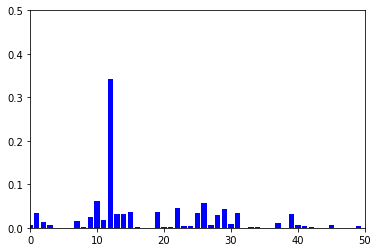

In [114]:
plt.bar(x, b, color = 'b')
plt.xlim(0,50)
plt.ylim(0,0.5)
plt.show()

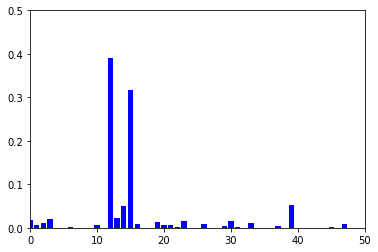

In [115]:
plt.bar(x, c, color = 'b')
plt.xlim(0,50)
plt.ylim(0,0.5)
plt.show()

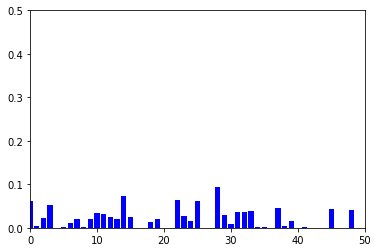

In [116]:
plt.bar(x, d, color = 'b')
plt.xlim(0,50)
plt.ylim(0,0.5)
plt.show()

In [144]:
a = torch.tensor(1)

In [145]:
a

tensor(1)

In [148]:
b = torch.tensor(2)
c = torch.tensor(100)

In [149]:
max(a, b,c)

tensor(100)